<a id='1'></a>

<table class="center" id="table1" style='color:white;font-size:30px;font-family:cursive;width:100%;margin-left:auto;margin-right:auto;'>
  <tr>
    <th style='border:3px solid #37a5fe;background-color:#37a5fe'>Table of Contents</th>
  </tr>
  <tr>
    <td style='border:3px solid #37a5fe;' bgcolor="#57b1fa"><a href="#imports" style='color:white;font-size:20px;'><div>Import Libraries & Load Data</div></a></td>
  </tr>
  <tr>
    <td style='border:3px solid #37a5fe;' bgcolor="#57b1fa"><a href="#eda" style='color:white;font-size:20px;'><div>Exploratory data analysis (EDA)</div></a></td>
  </tr>
  <tr>
    <td style='border:3px solid #37a5fe;' bgcolor="#57b1fa"><a href="#preprocess" style='color:white;font-size:20px;'><div>Preprocess Data</div></a></td>
  </tr>
  <tr>
    <td style='border:3px solid #37a5fe;' bgcolor="#57b1fa"><a href="#tokenize" style='color:white;font-size:20px;'><div>Set up Dataset & DataLoader</div></a></td>
  </tr>
  <tr>
    <td style='border:3px solid #37a5fe;' bgcolor="#57b1fa"><a href="#model" style='color:white;font-size:20px;'><div>Build Model & df</div></a></td>
  </tr>
  <tr>
    <td style='border:3px solid #37a5fe;' bgcolor="#57b1fa"><a href="#results" style='color:white;font-size:20px;'><div>Predict Test Set & Visualize Results</div></a></td>
  </tr>
</table>

---

<div style='border:5px solid #37a5fe; background-color:#37a5fe; color:white; border-radius:25px; text-align:center; font-family:cursive;'>
<h6><a id='imports' style='font-size:20px;font-weight:bold;color:white;'>Import Libraries & Load Data</a></h6>
<a href="#1" style='color:white;font-size:15px;'><div>Back to Table of Contents</div></a>
</div>

In [1]:
# the basic libraries
import re 
import string
import pandas as pd
import numpy as np
from tqdm import tqdm

# For splitting the data and to visualize results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For model building and dfing
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# For Loading BERT model and tokenizing tweets
from transformers import BertTokenizer, BertModel

# Stopwords for preprocessing
from wordcloud import STOPWORDS

# For displaying words in twitter logo shape
from wordcloud import WordCloud
from PIL import Image

# For plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# To display the plots
%matplotlib inline 

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Load data
df = pd.read_csv('Data/tweets_data.csv')

# Take a look at df data
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<div style='border:5px solid #37a5fe; background-color:#37a5fe; color:white; border-radius:25px; text-align:center; font-family:cursive;'>
<h6><a id='eda' style='font-size:20px;font-weight:bold;color:white;'>Exploratory data analysis (EDA)</a></h6>
<a href="#1" style='color:white;font-size:15px;'><div>Back to Table of Contents</div></a>
</div>

In [4]:
fig = make_subplots(
    rows=1, 
    cols=2, 
    specs=[[{"type": "pie"}, {"type": "bar"}]], 
    subplot_titles=('<b>Tweets Distribution</b>', '<b>Missing Values</b>')
)

df1 = pd.DataFrame(df['target'].value_counts())
df1['new_target'] = pd.DataFrame(['No Disasters', 'Disasters'])

missing_non_dis = df.loc[df['target']==0, ['keyword', 'location']].isnull().sum()
missing_dis = df.loc[df['target']==1, ['keyword', 'location']].isnull().sum()

trace1 = go.Pie(
    labels=df1.new_target, 
    values=df1.target, 
    hole=.5, 
    pull=[0.03, 0], 
    name='<b>Percentage</b>', 
    showlegend=False
)
trace2 = go.Bar(
    x=missing_non_dis.index, 
    y=missing_non_dis.values, 
    name='<b>No Disasters</b>', 
    marker_color='#0c8df5'
)
trace3 = go.Bar(
    x=missing_dis.index, 
    y=missing_dis.values, 
    name='<b>Disasters</b>', 
    marker_color='#75bffa'
)


fig.add_trace(trace1, 1, 1)
fig.update_layout(
    legend=dict(bgcolor='#b3dcfc', 
                bordercolor='#6e0a28',
                yanchor="top",
                y=1.05,
                xanchor="left",
                x=0.37), 
    legend_font=dict(color='#0c8df5')
)
fig.update_traces(
    marker=dict(colors=['#0c8df5', '#75bffa'])
)

fig.add_trace(trace2, 1, 2)
fig.add_trace(trace3, 1, 2)
fig.update_layout(
    xaxis_title="Columns",
    yaxis_title="Count",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#0c8df5"
    ),
    height=600, 
    width=1200
)

fig.show()

In [5]:
df['word count'] = df.text.apply(lambda x: len(x.split()))
df['tweet length'] = df.text.apply(len)
df['Target'] = np.where(df['target']==0, 'No Disaster', 'Disaster')

fig = make_subplots(rows=2, 
                    cols=2, 
                    subplot_titles=(
                        "<b>Tweets distribution by length</b>",
                        "<b>Tweets distribution by length</b>",
                        "<b>Tweets distribution by words count</b>",
                        "<b>Tweets distribution by words count</b>"
                    )
                   )

# Figure 1
fig.add_trace(
    go.Histogram(
        x=df.loc[df["Target"]=="No Disaster", "tweet length"],
        name="No Disaster length"
    ),
    row=1,
    col=1
)
fig.add_trace(
    go.Histogram(
        x=df.loc[df["Target"]=="Disaster", "tweet length"], 
        name="Disaster length"
    ),
    row=1,
    col=1
)

fig['layout']['xaxis1']['title']='Tweet length'
fig['layout']['yaxis1']['title']='Number of tweets'

# Figure 2
fig.add_trace(
    go.Box(
        x=df.loc[df["Target"]=="No Disaster", "Target"], 
        y=df.loc[df["Target"]=="No Disaster", "tweet length"], 
        name="word count",
        marker_color='#0c8df5',
        boxmean=True,
        showlegend=False
    ), 
    row=1, 
    col=2
)

fig.add_trace(
    go.Box(
        x=df.loc[df["Target"]=="Disaster", "Target"], 
        y=df.loc[df["Target"]=="Disaster", "tweet length"], 
        name="word count",
        marker_color='#75bffa',
        boxmean=True,
        showlegend=False
    ), 
    row=1, 
    col=2)

fig['layout']['xaxis2']['title']='Target'
fig['layout']['yaxis2']['title']='Tweet length'

# Figure 3
fig.add_trace(
    go.Histogram(
        x=df.loc[df["Target"]=="No Disaster", "word count"],
        name="No Disaster word count",
    ),
    row=2,
    col=1
)
fig.add_trace(
    go.Histogram(
        x=df.loc[df["Target"]=="Disaster", "word count"], 
        name="Disaster word count"
    ),
    row=2,
    col=1
)
fig['layout']['xaxis3']['title']='Word count'
fig['layout']['yaxis3']['title']='Number of tweets'


# Figure 4
fig.add_trace(
    go.Box(
        x=df.loc[df["Target"]=="No Disaster", "Target"], 
        y=df.loc[df["Target"]=="No Disaster", "word count"], 
        name="tweet length",
        marker_color='#0c8df5',
        boxmean=True,
        showlegend=False
    ), 
    row=2, 
    col=2)

fig.add_trace(
    go.Box(
        x=df.loc[df["Target"]=="Disaster", "Target"], 
        y=df.loc[df["Target"]=="Disaster", "word count"], 
        name="tweet length",
        marker_color='#75bffa',
        boxmean=True,
        showlegend=False,
    ), 
    row=2, 
    col=2)
fig['layout']['xaxis4']['title']='Target'
fig['layout']['yaxis4']['title']='Word count'



# Overlay both histograms
fig.update_layout(barmode='overlay', height=800, width=1200)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

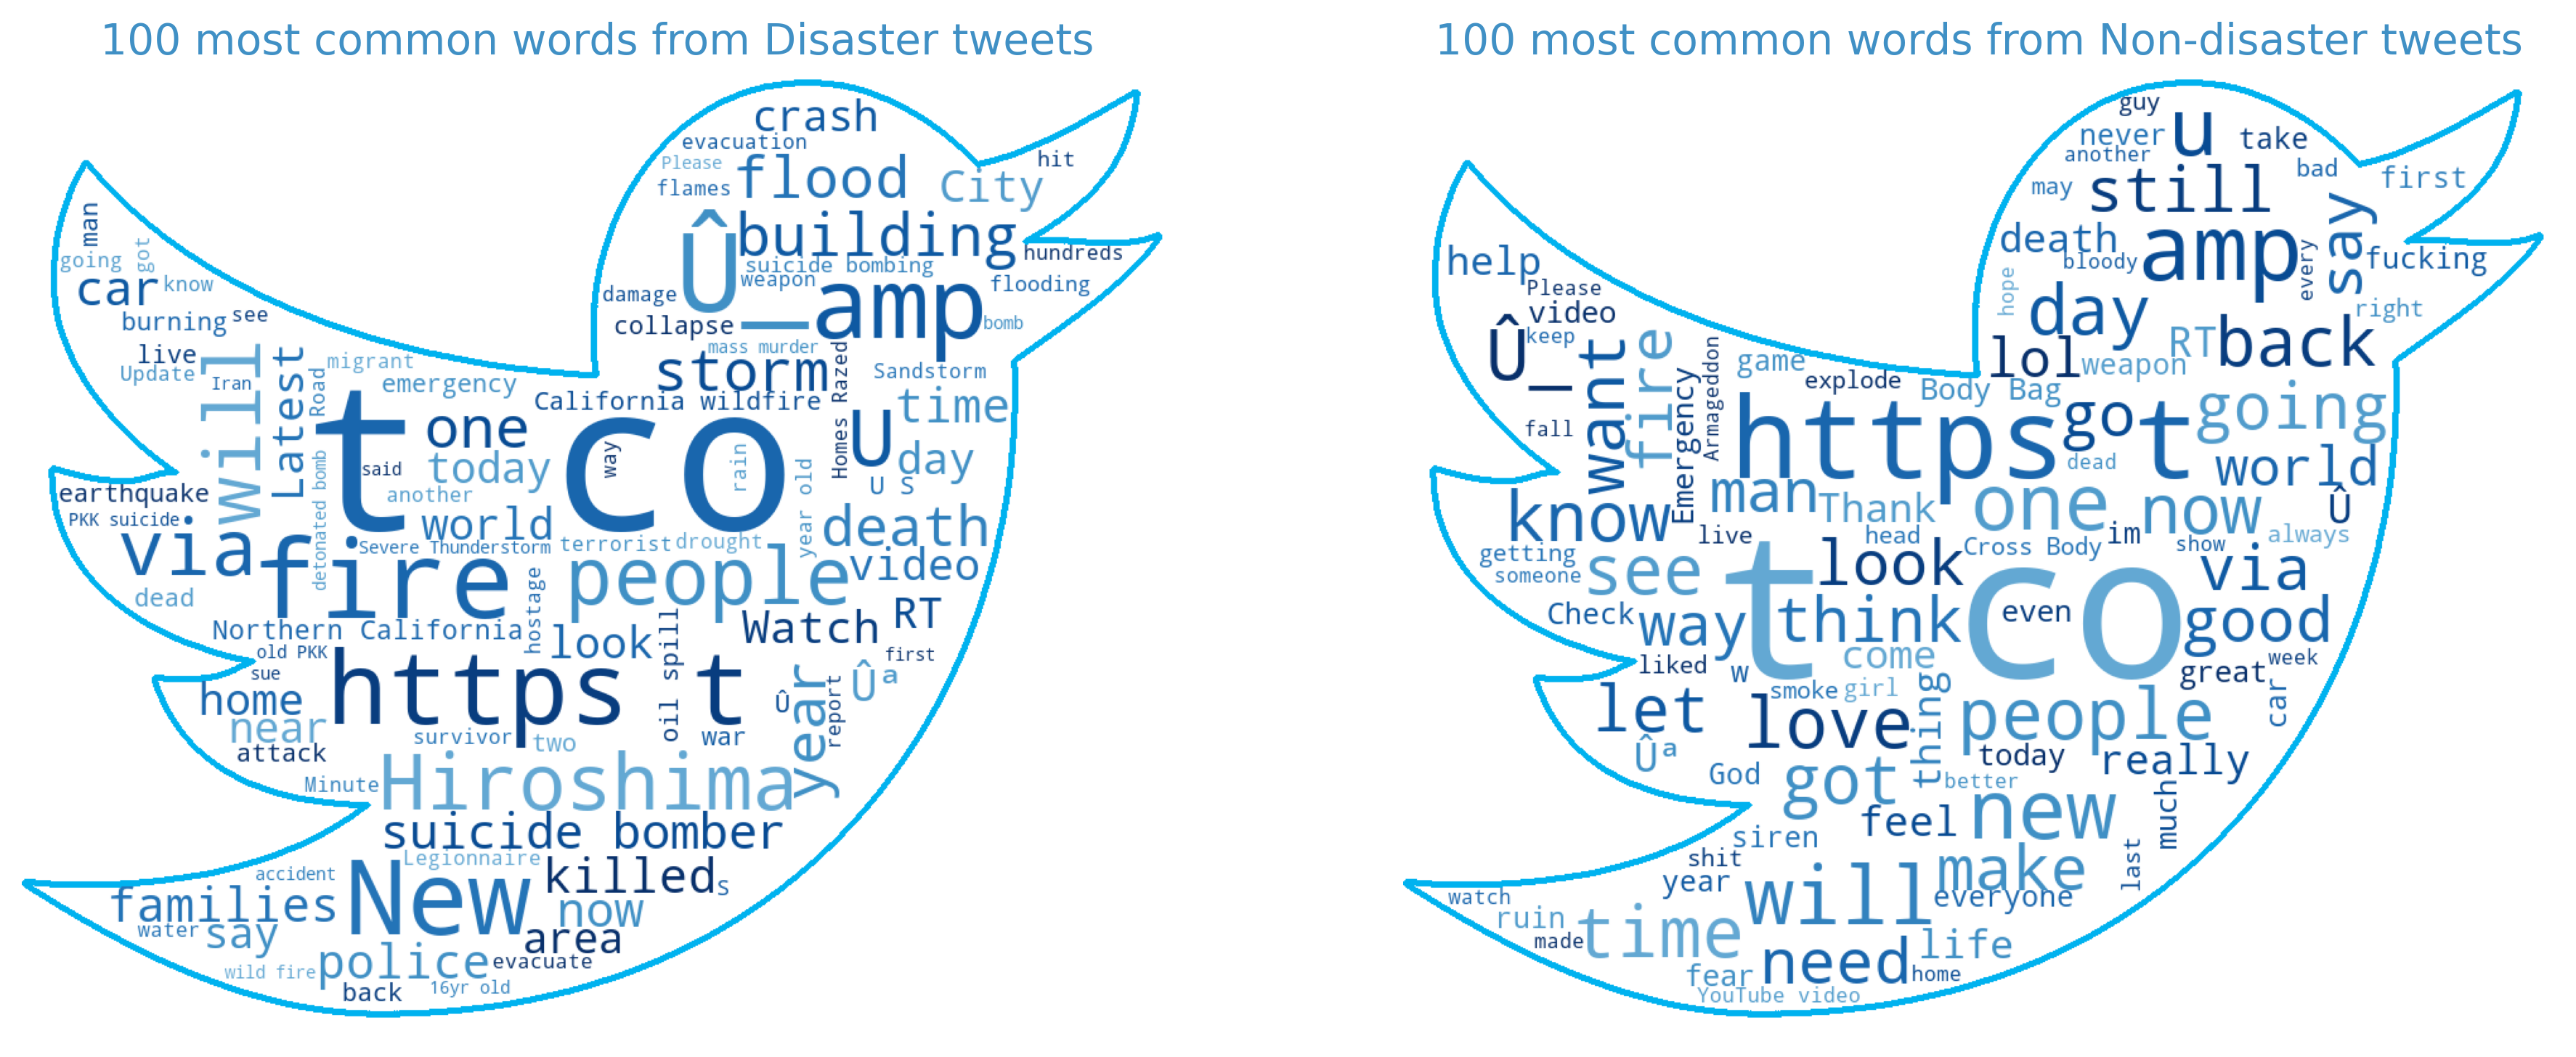

In [6]:
disastrous_text = " ".join(txt for txt in df.loc[df.target==1, 'text'])
non_disastrous_text = " ".join(txt for txt in df.loc[df.target==0, 'text'])

# import the desired colormap from matplotlib
cmap = mpl.cm.Blues(np.linspace(0,1,20)) 

# the darker part of the matrix is selected for readability
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 

def topicWordCloud(text, max_words,width, height, background_color, colormap, mask=None,):
    wordcloud = WordCloud(
        width=width, 
        height=height, 
        max_words=max_words, 
        mask=mask, 
        background_color=background_color, 
        colormap=colormap,
        contour_width=5, 
        contour_color='#00b2ef',
        random_state=42
    ).generate(text)
    return wordcloud

subtitles = ["100 most common words from Disaster tweets", 
             "100 most common words from Non-disaster tweets"]

mask = np.array(Image.open("Images/twitter-bird-logo.png"))
fig = plt.figure(figsize=(15,7), dpi=300)
for i, text_subt in enumerate(zip([disastrous_text, non_disastrous_text], subtitles)):
    ax = fig.add_subplot(1,2,i+1)
    wordcloud = topicWordCloud(text_subt[0], 100, 800, 400, "white", cmap, mask)
    ax.set_title(text_subt[1], color='#4090c5', fontsize=14)
    ax.imshow(wordcloud)
    ax.axis('off')

<p style='background-color:#75bffa;color:white;'><b>Even at a glance we can notice that there are more disaster related words in the first "bird" compared to second "bird".</b></p>

<div style='border:5px solid #37a5fe; background-color:#37a5fe; color:white; border-radius:25px; text-align:center; font-family:cursive;'>
    <h6><a id='preprocess' style='font-size:20px;font-weight:bold;color:white;'>Preprocess Data</a></h6>
<a href="#1" style='color:white;font-size:15px;'><div>Back to Table of Contents</div></a>
</div>

In [7]:
duplicates = df[df.duplicated(['text'])]
print(f"There are {duplicates.shape[0]} duplicated rows.")

There are 110 duplicated rows.


In [8]:
grouped_sum = duplicates[['text', 'target']].groupby(['text']).sum()
grouped_count = duplicates[['text', 'target']].groupby(['text']).count()
grouped = pd.concat([grouped_sum, grouped_count], axis=1)
grouped.columns = ['target_sum', 'duplicate_count']
grouped

,target_sum,duplicate_count
text,,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1,2
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,5,5
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,1,1
#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,1,1
#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way,1,1
...,...,...
incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1,1
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0,1
that exploded &amp; brought about the\nbeginning of universe matches what's\nmentioned in the versethe heaven and Earth\n(thus the universe),0,1


<p style='background-color:#75bffa;color:white;'>In the tabale above data are grouped by duplicates. if <i>target_sum</i> and <i>duplicate_count</i> match exactly it means that all targets of duplicates are disaster (1). If <i>target_sum</i> is 0 it means that there is no discrapancy between targets of duplicates, they are all no_disaster (0). Those cases are OK, but in any other case there is discrapancy. we will correct them manually and drop duplicates afterwards</p>

In [9]:
problematic = grouped.loc[(grouped['target_sum']!=grouped['duplicate_count']) & (grouped['target_sum']!=0)].index.to_list()
print(f'Number of duplicates that need attention: {len(problematic)} .')

Number of duplicates that need attention: 9 .


In [10]:
for i, tweet in enumerate(problematic):
    print(i, '-', tweet, end='\n\n')

0 - #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect

1 - #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption

2 - .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4

3 - CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring

4 - He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam

5 - Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife

6 - The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'

7 - To fight bioterrorism sir.

8 - that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been 

**Only 4th duplicate from *problematic* list seems to be disaster related.**

In [11]:
disaster = problematic[3]
no_disaster = problematic
del no_disaster[3]

In [12]:
df.loc[df['text'] == disaster, 'target'] = 1
df.loc[df['text'].isin(no_disaster), 'target'] = 0

# Drop duplicates with keeping only one for each
df.drop_duplicates(subset='text', inplace=True)
print(f'Final number of dfing rows: {df.shape[0]}.')

Final number of dfing rows: 7503.


In [13]:
# Fill missing values in kewords with nothing
df['keyword'] = df['keyword'].fillna('')

# Add keyword to tweets separating with space
df['text'] = df['text'] + ' ' + df['keyword']

# Drop unnecessary columns from df
df = df.drop(columns = ['id', 'location', 'keyword'])

In [14]:
# A handy set of abbreviations. big thanks to https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm#9.-Text-Preprocessing
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [15]:
# contractions from https://www.kaggle.com/code/tuckerarrants/bert-with-huggingface-transformers#III.-BERT
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [16]:
stop_words = list(STOPWORDS) + ['u', 'im', 'ur', 'us']

def text_cleaner(dataset):
    # Remove emojis
    # Thanks to https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7 for emoji removal code
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    dataset['text'] = dataset['text'].apply(lambda txt: emoji_pattern.sub(r'', str(txt)))
    
    # Converting each word to lowercase
    dataset['text']=dataset['text'].str.lower().str.strip()

    # Removing hashtags and mentions
    dataset['text'] = dataset['text'].apply(lambda txt: re.sub("(@[A-Za-z0-9_]+)|(#)","", txt))

    # Removing links
    dataset['text'] = dataset['text'].apply(lambda txt: re.sub(r"(http\S+)|(http)|(www.\S+)","", txt))
        
    # Split text into words, strip each word of spaces and remove stop words
    dataset['text'] = dataset['text'].apply(lambda txt: [w.strip() for w in txt.split() if w.strip() not in stop_words])

    # Replacing abbreviations with full form
    dataset['text'] = dataset['text'].apply(lambda lst: [abbreviations[w] if w in abbreviations else w for w in lst])
    
    # Expanding contractions
    dataset['text'] = dataset['text'].apply(lambda lst: [contractions[w] if w in contractions else w for w in lst])
    
    # Removing stopwords once again after expanding abbreviations and contractions
    dataset['text'] = dataset['text'].apply(lambda lst: " ".join([w.strip() for w in lst if w.strip() not in stop_words]))
    
    # Removing punctuations
    dataset['text'] = dataset['text'].apply(lambda txt: "".join([char for char in txt if char not in string.punctuation]))
    
    # Removing words that contain numbers or other non-alphanumeric characters
    dataset['text'] = dataset['text'].apply(lambda lst: [w for w in lst.split() if not bool(re.search('[^A-Za-z ]+', w))])

    # Removing one and two character words
    dataset['text'] = dataset['text'].apply(lambda lst: " ".join([l for l in lst if len(l)>2]))

In [17]:
text_cleaner(df)

<div style='border:5px solid #37a5fe; background-color:#37a5fe; color:white; border-radius:25px; text-align:center; font-family:cursive;'>
<h6><a id='tokenize' style='font-size:20px;font-weight:bold;color:white;'>Set up Dataset & DataLoader</a></h6>
<a href="#1" style='color:white;font-size:15px;'><div>Back to Table of Contents</div></a>
</div>

In [18]:
bert_model_name = 'bert-base-uncased'

# Get BERT layer
bert_model = BertModel.from_pretrained(bert_model_name)

# Get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# Split the data in two
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=df.target)
test_df, valid_df = train_test_split(test_df, test_size=0.5, random_state=42, shuffle=df.target)

In [20]:
train_df.shape, test_df.shape, valid_df.shape

((6002, 5), (750, 5), (751, 5))

In [21]:
class TweetsDataset(Dataset):
    def __init__(self, tweet, target, tokenizer, max_length):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.tweet[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')
        return [encoding['input_ids'].flatten(),
                encoding['attention_mask'].flatten(),
                torch.tensor(self.target[idx])]

In [22]:
max_length = 20
train_dataset = TweetsDataset(train_df.text.values, train_df.target.values, bert_tokenizer, max_length)
valid_dataset = TweetsDataset(valid_df.text.values, valid_df.target.values, bert_tokenizer, max_length)
test_dataset = TweetsDataset(test_df.text.values, test_df.target.values, bert_tokenizer, max_length)

In [23]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

<div style='border:5px solid #37a5fe; background-color:#37a5fe; color:white; border-radius:25px; text-align:center; font-family:cursive;'>
<h6><a id='model' style='font-size:20px;font-weight:bold;color:white;'>Build Model & Train</a></h6>
<a href="#1" style='color:white;font-size:15px;'><div>Back to Table of Contents</div></a>
</div>

In [24]:
class TweetClassifier(nn.Module):
  def __init__(self, n_classes):
    super(TweetClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(p = 0.5)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    bert = self.bert(input_ids, attention_mask)
    pooled_layer = bert[1]
    output = self.dropout(pooled_layer)
    output = self.linear(output)
    output = self.sigmoid(output)
    return output

In [25]:
model = TweetClassifier(2).to(device)
loss_criteria = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def training(model, data_loader):
    # Set the model to training mode
    model.train()
    train_loss = 0
    correct = 0
    
    pbar_batch = tqdm(position=0, leave=True, desc='Training', total = len(data_loader))
    pbar_batch.reset()
    
    for batch, (input_ids, attention_mask, target) in enumerate(data_loader):
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
        
        #feedforward
        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
        
        # Calculate the accuracy
        predicted = output.argmax(axis=1)
        correct += torch.sum(target==predicted).item()

        pbar_batch.update(1)
    
    # calculate total training accuracy for this epoch
    accuracy = correct / len(data_loader.dataset)*100
    
    #Return average loss
    avg_loss = train_loss / (batch+1)
    
    print(f'Training loss: {avg_loss:.4f}, \
          Training accuracy: {correct}/{len(data_loader.dataset)} ({accuracy:.3f}%)\n')
    return avg_loss, accuracy

In [27]:
def validation(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    valid_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch, (input_ids, attention_mask, target) in enumerate(data_loader):
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            
            # Get the predictions
            output = model(input_ids, attention_mask)

            # calculate the loss
            loss = loss_criteria(output, target)
            valid_loss += loss.item()

            # Calculate the accuracy
            predicted = output.argmax(axis=1)
            correct += torch.sum(target==predicted).item()
                        
    # Calculate total accuracy for this epoch
    accuracy = correct/len(data_loader.dataset)*100

    avg_loss = valid_loss / (batch+1)
    print(f'Validation loss: {avg_loss:.4f}, \
          Validation Accuracy: {correct}/{len(data_loader.dataset)} ({accuracy:.3f}%)\n')
   
    # return average loss for the epoch
    return avg_loss, accuracy

In [28]:
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
validation_accuracies = []
training_accuracies = []

epochs = 20
for epoch in range(1, epochs + 1):

    # print the epoch number
    print(f'Epoch: {epoch}')
    
    # Feed training data into the model to optimize the weights
    train_loss, train_accuracy = training(model, train_loader)
    
    # Feed the test data into the model to check its performance
    valid_loss, valid_accuracy = validation(model, valid_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_accuracies.append(train_accuracy)
    validation_loss.append(valid_loss)
    validation_accuracies.append(valid_accuracy)

    # Save model after each epoch
    torch.save({
                'epoch': epoch_nums,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'Models/model_{epoch}.pt')

Epoch: 1


Training: 100%|██████████| 94/94 [00:34<00:00,  2.69it/s]


Training loss: 0.6935,           Training accuracy: 3069/6002 (51.133%)

Validation loss: 0.6817,           Validation Accuracy: 496/751 (66.045%)

Epoch: 2


Training: 100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Training loss: 0.6651,           Training accuracy: 3891/6002 (64.828%)

Validation loss: 0.6332,           Validation Accuracy: 562/751 (74.834%)

Epoch: 3


Training: 100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


Training loss: 0.6204,           Training accuracy: 4591/6002 (76.491%)

Validation loss: 0.5993,           Validation Accuracy: 591/751 (78.695%)

Epoch: 4


Training: 100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Training loss: 0.5931,           Training accuracy: 4751/6002 (79.157%)

Validation loss: 0.5819,           Validation Accuracy: 590/751 (78.562%)

Epoch: 5


Training: 100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Training loss: 0.5733,           Training accuracy: 4803/6002 (80.023%)

Validation loss: 0.5624,           Validation Accuracy: 598/751 (79.627%)

Epoch: 6


Training: 100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Training loss: 0.5548,           Training accuracy: 4881/6002 (81.323%)

Validation loss: 0.5495,           Validation Accuracy: 603/751 (80.293%)

Epoch: 7


Training: 100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Training loss: 0.5399,           Training accuracy: 4898/6002 (81.606%)

Validation loss: 0.5369,           Validation Accuracy: 610/751 (81.225%)

Epoch: 8


Training: 100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Training loss: 0.5307,           Training accuracy: 4906/6002 (81.739%)

Validation loss: 0.5244,           Validation Accuracy: 610/751 (81.225%)

Epoch: 9


Training: 100%|██████████| 94/94 [00:28<00:00,  3.36it/s]


Training loss: 0.5167,           Training accuracy: 4966/6002 (82.739%)

Validation loss: 0.5204,           Validation Accuracy: 612/751 (81.491%)

Epoch: 10


Training: 100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Training loss: 0.5087,           Training accuracy: 5003/6002 (83.356%)

Validation loss: 0.5102,           Validation Accuracy: 616/751 (82.024%)

Epoch: 11


Training: 100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Training loss: 0.5000,           Training accuracy: 5019/6002 (83.622%)

Validation loss: 0.5084,           Validation Accuracy: 615/751 (81.891%)

Epoch: 12


Training: 100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


Training loss: 0.4936,           Training accuracy: 5031/6002 (83.822%)

Validation loss: 0.5045,           Validation Accuracy: 612/751 (81.491%)

Epoch: 13


Training: 100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Training loss: 0.4872,           Training accuracy: 5085/6002 (84.722%)

Validation loss: 0.4979,           Validation Accuracy: 621/751 (82.690%)

Epoch: 14


Training: 100%|██████████| 94/94 [00:28<00:00,  3.27it/s]


Training loss: 0.4830,           Training accuracy: 5074/6002 (84.538%)

Validation loss: 0.4951,           Validation Accuracy: 620/751 (82.557%)

Epoch: 15


Training: 100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


Training loss: 0.4770,           Training accuracy: 5110/6002 (85.138%)

Validation loss: 0.4963,           Validation Accuracy: 619/751 (82.423%)

Epoch: 16


Training: 100%|██████████| 94/94 [00:28<00:00,  3.25it/s]


Training loss: 0.4707,           Training accuracy: 5141/6002 (85.655%)

Validation loss: 0.4918,           Validation Accuracy: 620/751 (82.557%)

Epoch: 17


Training: 100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Training loss: 0.4675,           Training accuracy: 5147/6002 (85.755%)

Validation loss: 0.4909,           Validation Accuracy: 618/751 (82.290%)

Epoch: 18


Training: 100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Training loss: 0.4636,           Training accuracy: 5159/6002 (85.955%)

Validation loss: 0.4913,           Validation Accuracy: 619/751 (82.423%)

Epoch: 19


Training: 100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Training loss: 0.4575,           Training accuracy: 5202/6002 (86.671%)

Validation loss: 0.4826,           Validation Accuracy: 628/751 (83.622%)

Epoch: 20


Training: 100%|██████████| 94/94 [00:28<00:00,  3.30it/s]


Training loss: 0.4557,           Training accuracy: 5201/6002 (86.654%)

Validation loss: 0.4814,           Validation Accuracy: 626/751 (83.356%)



<div style='border:5px solid #37a5fe; background-color:#37a5fe; color:white; border-radius:25px; text-align:center; font-family:cursive;'>
<h6><a id='results' style='font-size:20px;font-weight:bold;color:white;'>Predict Test Set & Visualize Results</a></h6>
<a href="#1" style='color:white;font-size:15px;'><div>Back to Table of Contents</div></a>
</div>

In [29]:
# Choose model based on lowest validation loss
best_epoch = np.array(validation_loss).argmin()+1
print(f"Best model is with epoch:", best_epoch)

Best model is with epoch: 20


In [30]:
# Load the best model
model = TweetClassifier(2).to(device)
loss_criteria = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)

checkpoint = torch.load(f"Models/model_{best_epoch}.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
with torch.no_grad():
    for batch, (input_ids, attention_mask, target) in enumerate(test_loader):
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
        
        # Get the predictions
        output = model(input_ids, attention_mask)
        predicted = output.argmax(axis=1)

In [32]:
test_df['prediction'] = predicted.cpu()
mapping = {0 : "No Disaster", 1 : "Disaster"}
test_df['prediction'] = test_df['prediction'].map(mapping)

In [33]:
print(classification_report(test_df['Target'], test_df['prediction']))

              precision    recall  f1-score   support

    Disaster       0.79      0.76      0.77       325
 No Disaster       0.82      0.84      0.83       425

    accuracy                           0.81       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.81      0.80       750



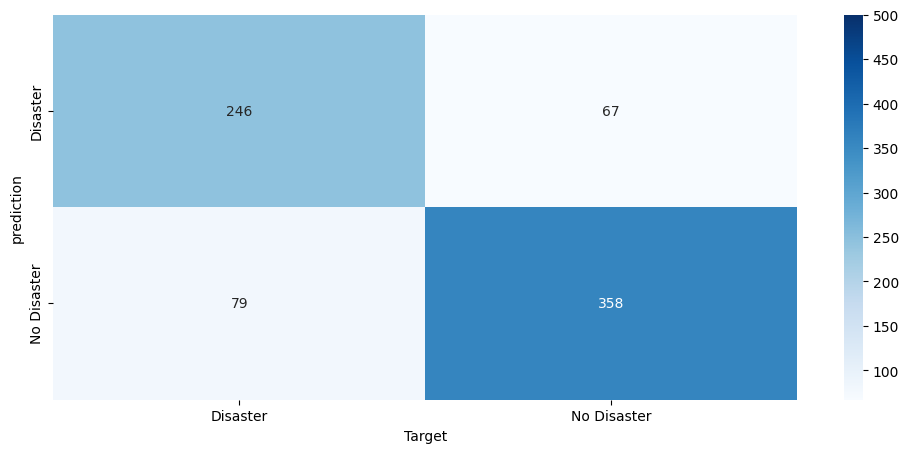

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(pd.crosstab(test_df['prediction'], test_df['Target']),
            cmap='Blues', ax=ax, annot=True, fmt=',.0f', vmax=500);